<a href="https://colab.research.google.com/github/Abhishek734/Deep-learning-practice/blob/master/cat-dog/Keras_CNN_model_for_cat_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [0]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img


## Define Variables

In [0]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Load the data from kaggle

In [184]:
from google.colab import files
files.upload()

# Let's make sure the kaggle.json file is present.
# !ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Copy the stackoverflow data set locally.
# accept the terms and conditions 
!kaggle competitions download -c dogs-vs-cats

from zipfile import ZipFile

filename='train.zip'
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('done!')

filename='test1.zip'
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('done!')

Saving kaggle.json to kaggle (3).json
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
done!
done!


## Prepare Training Data

In [0]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split(".")[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [186]:
df.head()

,filename,category
0,dog.10039.jpg,1
1,cat.3790.jpg,0
2,dog.5107.jpg,1
3,dog.10857.jpg,1
4,cat.8446.jpg,0


## See total counts

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


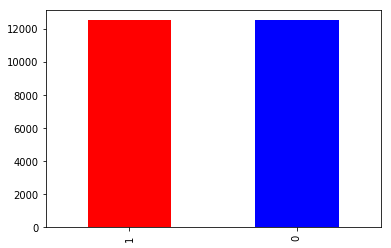

In [187]:
df['category'].value_counts().plot.bar(colors = ("red","blue"))

## lets see a sample data

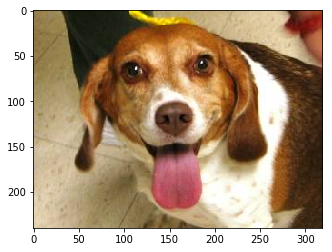

In [188]:

sample_img = random.choice(filenames)
img = load_img("train/" + sample_img)
plt.imshow(img)

## Building Keras CNN model


In [189]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_29 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_30 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 64)       

In [0]:
# help(Conv2D)

## Callbacks

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [0]:
earlystop = EarlyStopping(patience=10)

## Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
callbacks = [earlystop, learning_rate_reduction]

## Data Preparation

Because we will use image genaretor with **class_mode="categorical"**. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.


So we will convert 1 to dog and 0 to cat


In [0]:
df["category"] = df["category"].replace({0:'cat', 1:'dog'})

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [197]:
print(validate_df.shape)
print(train_df.shape)

(5000, 2)
(20000, 2)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


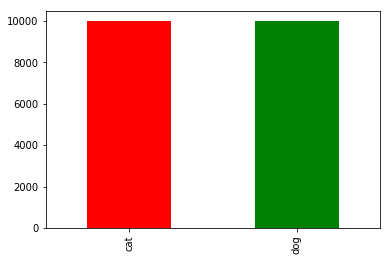

In [198]:
train_df['category'].value_counts().plot.bar(colors = ['red','green'])

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


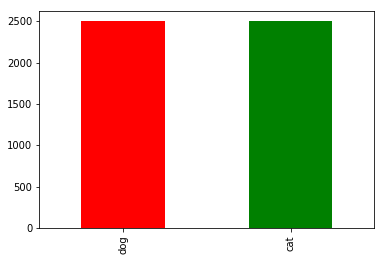

In [199]:
validate_df['category'].value_counts().plot.bar(colors = ['red','green'])


In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Training Generator

In [201]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Validation generator

In [202]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [203]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


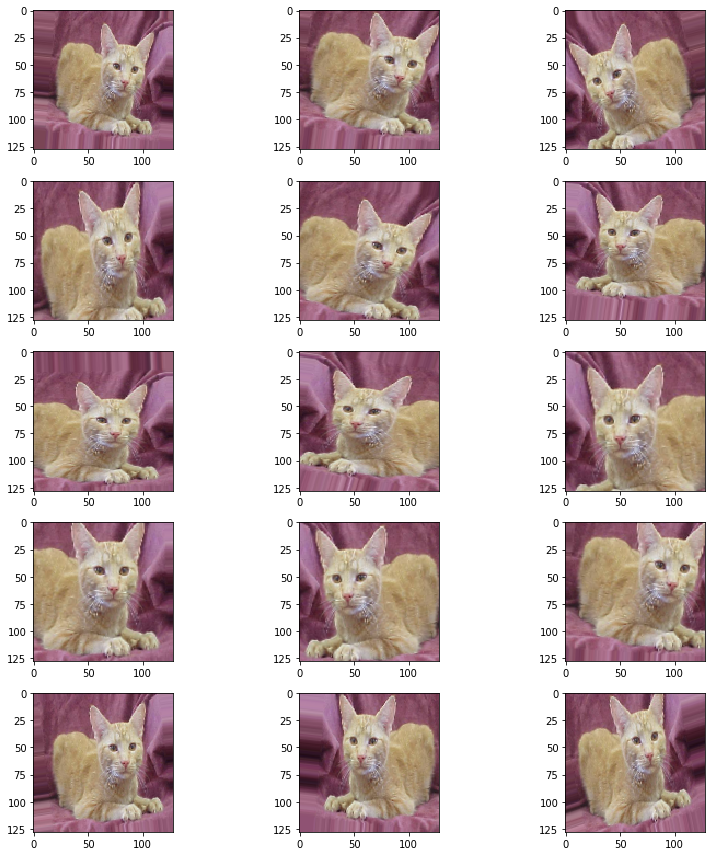

In [204]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# lets fit our model

In [207]:
epochs=3 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 126s 94ms/step - loss: 0.6089 - acc: 0.6845 - val_loss: 0.5002 - val_acc: 0.7602
Epoch 2/10
1333/1333 [==============================] - 124s 93ms/step - loss: 0.5226 - acc: 0.7475 - val_loss: 1.9973 - val_acc: 0.5258
Epoch 3/10
1333/1333 [==============================] - 125s 94ms/step - loss: 0.4825 - acc: 0.7794 - val_loss: 0.3903 - val_acc: 0.8311
Epoch 4/10
1333/1333 [==============================] - 125s 93ms/step - loss: 0.4547 - acc: 0.7862 - val_loss: 0.4354 - val_acc: 0.8088
Epoch 5/10
1333/1333 [==============================] - 124s 93ms/step - loss: 0.4280 - acc: 0.8053 - val_loss: 0.4569 - val_acc: 0.8247

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
1333/1333 [==============================] - 124s 93ms/step - loss: 0.3821 - acc: 0.8311 - val_loss: 0.3242 - val_acc: 0.8616
Epoch 7/10
1333/1333 [==============================] - 124s 93ms/step - loss: 0.3666 - acc: 0.83

In [0]:
model.save_weights("model.h5")

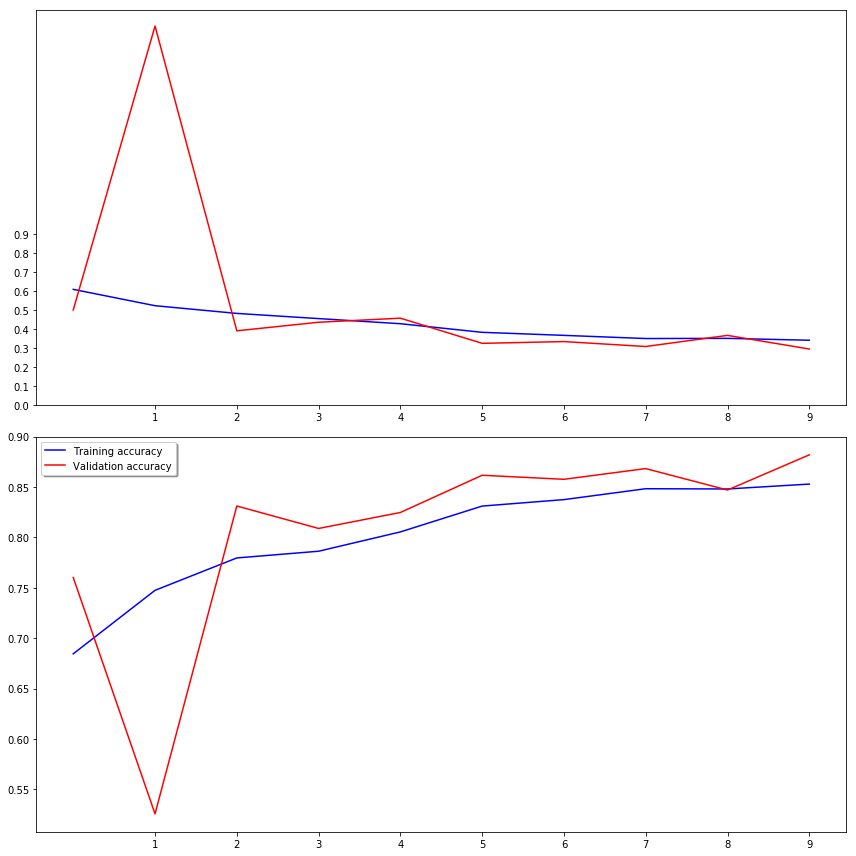

In [215]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare test set

In [0]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    "filename":test_filenames
})
nb_sample = test_df.shape[0]

In [222]:
# os.listdir("test1/")
nb_sample

12500

## Creating Testing Generator

In [226]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "test1/",
    x_col='filename',
    y_col = None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

# test_gen = ImageDataGenerator(rescale=1./255)
# test_generator = test_gen.flow_from_dataframe(
#     test_df, 
#     "test1/", 
#     x_col='filename',
#     y_col=None,
#     class_mode=None,
#     target_size=IMAGE_SIZE,
#     batch_size=batch_size,
#     shuffle=False
# )

Found 12500 validated image filenames.


## Prediction

In [0]:
##

In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_sample/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [0]:
test_df["category"] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [0]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [0]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


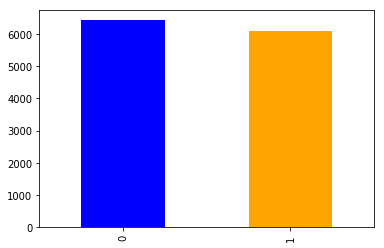

In [234]:
## virtaulize results
test_df['category'].value_counts().plot.bar(colors = ("blue",'orange'))

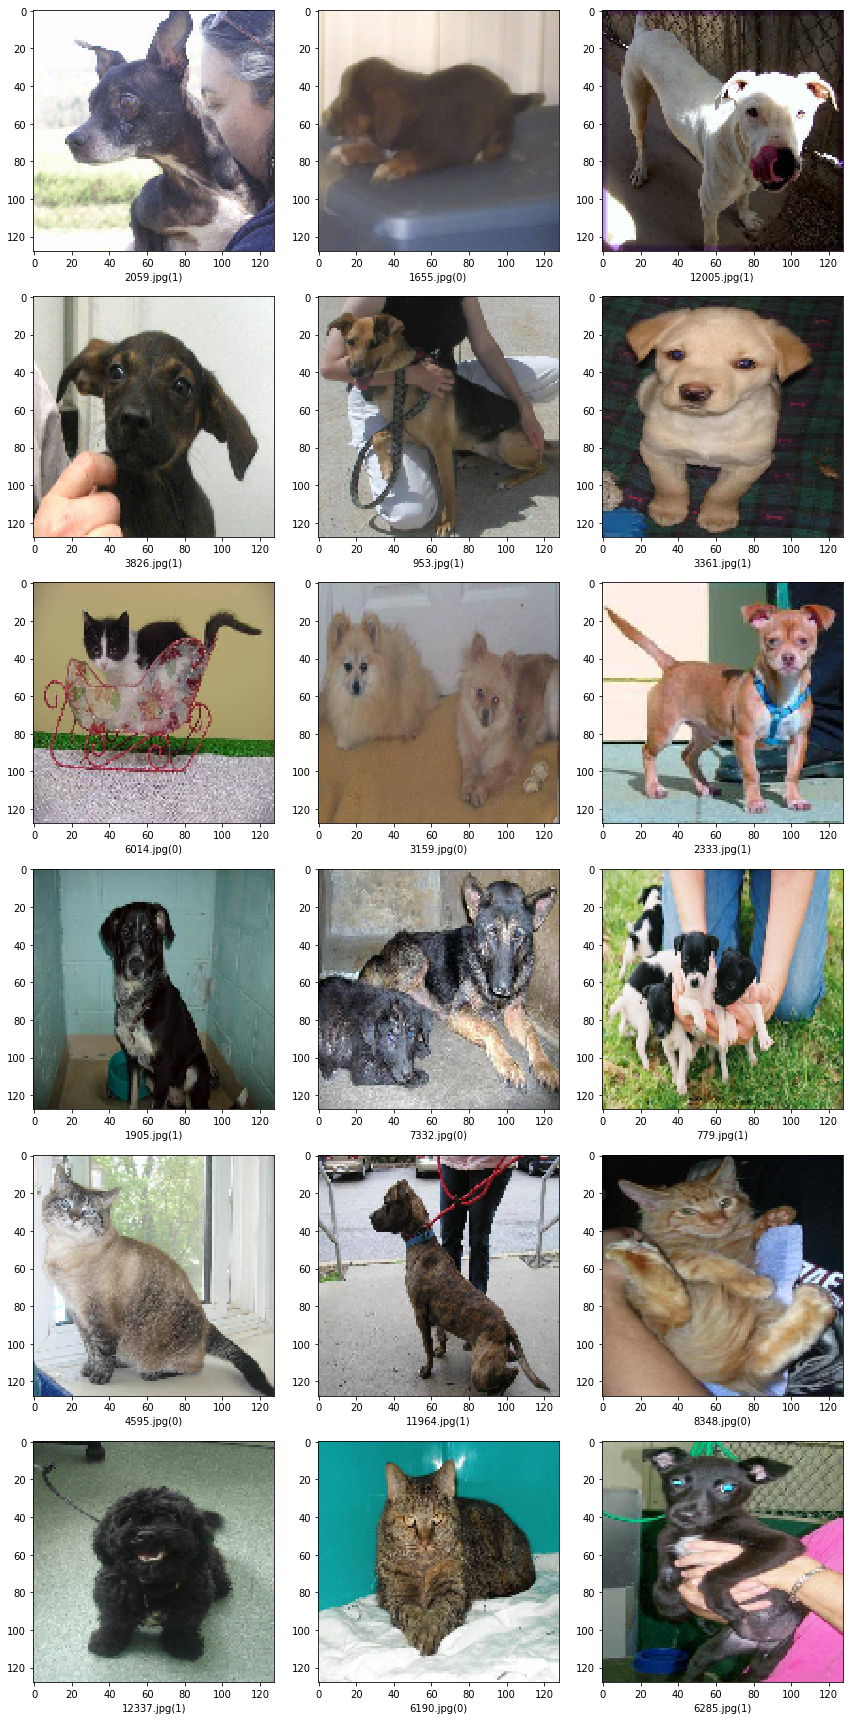

In [236]:
## see predicted result with images

sample_test = test_df.head(18)
# sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [0]:
# sub
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [0]:
# pd.read_csv("submission.csv")